<a href="https://colab.research.google.com/github/awhitehouse1/project_voting/blob/main/Model_Project_Voting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Model Work

In [1]:
! git clone https://www.github.com/awhitehouse1/project_voting/

Cloning into 'project_voting'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 112 (delta 9), reused 4 (delta 4), pack-reused 93
Receiving objects: 100% (112/112), 32.94 MiB | 13.40 MiB/s, done.
Resolving deltas: 100% (46/46), done.


In [2]:
!pip3 install mapclassify

In [20]:
import pandas as pd
import geopandas as gpd
import mapclassify
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import seaborn as sns
from sklearn.utils import resample

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [50]:

gdf = gpd.read_file('/content/drive/My Drive/VirginiaCounty_ClippedToShoreline.shx') # Load Virginia shapefile for maps
vdf = pd.read_csv('./project_voting/clean_data/clean_vdf.csv')
cdf = pd.read_csv('./project_voting/clean_data/clean_cdf.csv')
nhgis = pd.read_csv('./project_voting/clean_data/clean_NHGIS_county_data.csv')

merged_df = pd.merge(vdf, cdf, left_on='county_fips', right_on='FIPS', how='left')

In [51]:
#standardize county names in gdf
gdf['NAME'] = gdf['NAME'].str.replace(' County', '')  # Remove 'County' from county names

#standardize county names in merged_df
merged_df['county_name'] = merged_df['county_name'].str.upper()  # Convert county names to uppercase

#names in gdf uppercase
gdf['NAME'] = gdf['NAME'].str.upper()

#names in merged_df uppercase
merged_df['county_name'] = merged_df['county_name'].str.upper()

#remove spaces between words in county names in gdf
gdf['NAME'] = gdf['NAME'].str.replace(' ', '')

#remove spaces between words in county names in merged_df
merged_df['county_name'] = merged_df['county_name'].str.replace(' ', '')

#unique county names from gdf and merged_df
unique_county_names_gdf = gdf['NAME'].unique()
unique_county_names_merged_df = merged_df['county_name'].unique()

common_county_names = set(unique_county_names_gdf) & set(unique_county_names_merged_df)

unique_county_names_gdf_only = set(unique_county_names_gdf) - common_county_names
unique_county_names_merged_df_only = set(unique_county_names_merged_df) - common_county_names

print("Common county names between datasets:", common_county_names)
print("County names unique to gdf:", unique_county_names_gdf_only)
print("County names unique to merged_df:", unique_county_names_merged_df_only)



Common county names between datasets: {'FLUVANNA', 'ISLEOFWIGHT', 'MADISON', 'LEE', 'CLARKE', 'DICKENSON', 'WISE', 'NORTHAMPTON', 'ROCKBRIDGE', 'MECKLENBURG', 'LEXINGTON', 'CARROLL', 'BUCKINGHAM', 'LANCASTER', 'RAPPAHANNOCK', 'AMELIA', 'SMYTH', 'CHARLOTTESVILLE', 'FREDERICK', 'CULPEPER', 'LOUISA', 'CHARLESCITY', 'APPOMATTOX', 'PULASKI', 'DINWIDDIE', 'PAGE', 'SOUTHAMPTON', 'ROCKINGHAM', 'HIGHLAND', 'RUSSELL', 'FRANKLIN', 'LOUDOUN', 'ROANOKE', 'SCOTT', 'BEDFORD', 'ACCOMACK', 'FLOYD', 'YORK', 'GOOCHLAND', 'KINGWILLIAM', 'WARREN', 'PITTSYLVANIA', 'KINGANDQUEEN', 'CHESTERFIELD', 'GREENE', 'ALLEGHANY', 'PETERSBURG', 'FAUQUIER', 'BUCHANAN', 'CAMPBELL', 'WILLIAMSBURG', 'SUSSEX', 'STAUNTON', 'ESSEX', 'POQUOSON', 'GALAX', 'SALEM', 'ALEXANDRIA', 'MARTINSVILLE', 'NORTHUMBERLAND', 'LUNENBURG', 'SHENANDOAH', 'SUFFOLK', 'BLAND', 'HALIFAX', 'PRINCEGEORGE', 'PRINCEWILLIAM', 'FREDERICKSBURG', 'WASHINGTON', 'BRISTOL', 'COLONIALHEIGHTS', 'NELSON', 'CUMBERLAND', 'BATH', 'AUGUSTA', 'BOTETOURT', 'AMHERST', '

In [52]:
#merge shapefile and merged_df
gdf['FIPS_left'] = pd.to_numeric(gdf['STCOFIPS'])
df = gdf.merge(merged_df,left_on='FIPS_left',right_on='county_fips')
virginia_data = nhgis[nhgis['state'] == 'Virginia']

In [9]:
virginia_data.head()

,state,county,M_18_to_29,M_30_to_49,M_50_to_64,M_65_plus,F_18_to_29,F_30_to_49,F_50_to_64,F_65_plus,income_under_30000,income_30000_to_49999,income_50000_to_99999,income_100000_plus
2821,Virginia,ACCOMACKCOUNTY,1978,3336,3469,3160,1886,3729,3743,4136,4332,2872,4170,2264
2822,Virginia,ALBEMARLECOUNTY,9574,12798,9691,7732,10359,13006,11331,11347,6480,6147,12214,17660
2823,Virginia,ALLEGHANYCOUNTY,1040,1464,1714,1448,889,1637,1797,2032,2129,1268,1904,1257
2824,Virginia,AMELIACOUNTY,755,1559,1532,1065,827,1420,1594,1379,1078,937,1705,1390
2825,Virginia,AMHERSTCOUNTY,2216,3581,3449,2620,2280,3701,3721,3717,3078,2536,3799,2906


In [55]:
#previous election data
vdf_previous_election = vdf.loc[ vdf['year']==2020,:]
Rvotes = vdf_previous_election.loc[(vdf_previous_election['party']=='REPUBLICAN'),:].groupby('county_fips')['candidatevotes'].sum()
Rvotes = Rvotes.rename('repub_2020')
Dvotes = vdf_previous_election.loc[(vdf_previous_election['party']=='DEMOCRAT'),:].groupby('county_fips')['candidatevotes'].sum()
Dvotes = Dvotes.rename('dem_2020')

Dvotes_index = Dvotes.index
FIP = Dvotes_index.tolist()
print(FIP)
virginia_data['county_fips'] = FIP

virginia_data = virginia_data.merge(Dvotes,left_on='county_fips',right_on='county_fips')
virginia_data = virginia_data.merge(Rvotes,left_on='county_fips',right_on='county_fips')
print(virginia_data)

[51001, 51003, 51005, 51007, 51009, 51011, 51013, 51015, 51017, 51019, 51021, 51023, 51025, 51027, 51029, 51031, 51033, 51035, 51036, 51037, 51041, 51043, 51045, 51047, 51049, 51051, 51053, 51057, 51059, 51061, 51063, 51065, 51067, 51069, 51071, 51073, 51075, 51077, 51079, 51081, 51083, 51085, 51087, 51089, 51091, 51093, 51095, 51097, 51099, 51101, 51103, 51105, 51107, 51109, 51111, 51113, 51115, 51117, 51119, 51121, 51125, 51127, 51131, 51133, 51135, 51137, 51139, 51141, 51143, 51145, 51147, 51149, 51153, 51155, 51157, 51159, 51161, 51163, 51165, 51167, 51169, 51171, 51173, 51175, 51177, 51179, 51181, 51183, 51185, 51187, 51191, 51193, 51195, 51197, 51199, 51510, 51520, 51530, 51540, 51550, 51570, 51580, 51590, 51595, 51600, 51610, 51620, 51630, 51640, 51650, 51660, 51670, 51678, 51680, 51683, 51685, 51690, 51700, 51710, 51720, 51730, 51735, 51740, 51750, 51760, 51770, 51775, 51790, 51800, 51810, 51820, 51830, 51840]
        state             county  M_18_to_29  M_30_to_49  M_50_to_64

<ipython-input-55-2bca78f4d309>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  virginia_data['county_fips'] = FIP


In [56]:
vdf_previous_election_2016 = vdf.loc[vdf['year'] == 2016, :]
Rvotes_2016 = vdf_previous_election_2016.loc[(vdf_previous_election_2016['party'] == 'REPUBLICAN'), :].groupby('county_fips')['candidatevotes'].sum()
Rvotes_2016 = Rvotes_2016.rename('repub_2016')
Dvotes_2016 = vdf_previous_election_2016.loc[(vdf_previous_election_2016['party'] == 'DEMOCRAT'), :].groupby('county_fips')['candidatevotes'].sum()
Dvotes_2016 = Dvotes_2016.rename('dem_2016')

Dvotes_index_2016 = Dvotes_2016.index
FIP = Dvotes_index_2016.tolist()
print(FIP)

virginia_data = virginia_data.merge(Dvotes_2016, left_on='county_fips', right_on='county_fips')
virginia_data = virginia_data.merge(Rvotes_2016, left_on='county_fips', right_on='county_fips')

[51001, 51003, 51005, 51007, 51009, 51011, 51013, 51015, 51017, 51019, 51021, 51023, 51025, 51027, 51029, 51031, 51033, 51035, 51036, 51037, 51041, 51043, 51045, 51047, 51049, 51051, 51053, 51057, 51059, 51061, 51063, 51065, 51067, 51069, 51071, 51073, 51075, 51077, 51079, 51081, 51083, 51085, 51087, 51089, 51091, 51093, 51095, 51097, 51099, 51101, 51103, 51105, 51107, 51109, 51111, 51113, 51115, 51117, 51119, 51121, 51125, 51127, 51131, 51133, 51135, 51137, 51139, 51141, 51143, 51145, 51147, 51149, 51153, 51155, 51157, 51159, 51161, 51163, 51165, 51167, 51169, 51171, 51173, 51175, 51177, 51179, 51181, 51183, 51185, 51187, 51191, 51193, 51195, 51197, 51199, 51510, 51515, 51520, 51530, 51540, 51550, 51570, 51580, 51590, 51595, 51600, 51610, 51620, 51630, 51640, 51650, 51660, 51670, 51678, 51680, 51683, 51685, 51690, 51700, 51710, 51720, 51730, 51735, 51740, 51750, 51760, 51770, 51775, 51790, 51800, 51810, 51820, 51830, 51840]


###Linear Regression

In [57]:
cats = ['M_18_to_29', 'M_30_to_49', 'M_50_to_64', 'M_65_plus', 'F_18_to_29', 'F_30_to_49', 'F_50_to_64', 'F_65_plus', 'income_under_30000', 'income_30000_to_49999', 'income_50000_to_99999', 'income_100000_plus']

for cat in cats:
    virginia_data[cat] = pd.to_numeric(virginia_data[cat], errors='coerce')

#linear regression
X_numeric = virginia_data[cats]
y_2020 = virginia_data[['dem_2020', 'repub_2020']]
y_2016 = virginia_data[['dem_2016', 'repub_2016']]

X_train_numeric, X_test_numeric, y_train_2020, y_test_2020 = train_test_split(X_numeric, y_2020, test_size=0.2, random_state=42)

#linear regression for 2020 data
linear_reg_numeric_2020 = LinearRegression()
linear_reg_numeric_2020.fit(X_train_numeric, y_train_2020)
y_train_pred_2020 = linear_reg_numeric_2020.predict(X_train_numeric)
y_test_pred_2020 = linear_reg_numeric_2020.predict(X_test_numeric)
train_rmse_numeric_2020 = np.sqrt(mean_squared_error(y_train_2020, y_train_pred_2020))
test_rmse_numeric_2020 = np.sqrt(mean_squared_error(y_test_2020, y_test_pred_2020))
train_r2_numeric_2020 = r2_score(y_train_2020, y_train_pred_2020)
test_r2_numeric_2020 = r2_score(y_test_2020, y_test_pred_2020)
test_mae_2020 = mean_absolute_error(y_test_2020, y_test_pred_2020)
print('2020 Model Train RMSE:', train_rmse_numeric_2020, 'R^2:', train_r2_numeric_2020)
print('2020 Model Test RMSE:', test_rmse_numeric_2020, 'R^2:', test_r2_numeric_2020)
print('2020 Model Test MAE:', test_mae_2020)

#train-test split for 2016 data
X_train_numeric_2016, X_test_numeric_2016, y_train_2016, y_test_2016 = train_test_split(X_numeric, y_2016, test_size=0.2, random_state=42)

#linear regression for 2016 data
linear_reg_numeric_2016 = LinearRegression()
linear_reg_numeric_2016.fit(X_train_numeric_2016, y_train_2016)
y_train_pred_2016 = linear_reg_numeric_2016.predict(X_train_numeric_2016)
y_test_pred_2016 = linear_reg_numeric_2016.predict(X_test_numeric_2016)
train_rmse_numeric_2016 = np.sqrt(mean_squared_error(y_train_2016, y_train_pred_2016))
test_rmse_numeric_2016 = np.sqrt(mean_squared_error(y_test_2016, y_test_pred_2016))
train_r2_numeric_2016 = r2_score(y_train_2016, y_train_pred_2016)
test_r2_numeric_2016 = r2_score(y_test_2016, y_test_pred_2016)
test_mae_2016 = mean_absolute_error(y_test_2016, y_test_pred_2016)
print('2016 Model Train RMSE:', train_rmse_numeric_2016, 'R^2:', train_r2_numeric_2016)
print('2016 Model Test RMSE:', test_rmse_numeric_2016, 'R^2:', test_r2_numeric_2016)
print('2016 Model Test MAE:', test_mae_2016)

2020 Model Train RMSE: 3461.737017783332 R^2: 0.9839043292786235
2020 Model Test RMSE: 4022.6980891680023 R^2: 0.9089262880380649
2020 Model Test MAE: 2602.092297917564
2016 Model Train RMSE: 3274.956563137034 R^2: 0.984335718535841
2016 Model Test RMSE: 3929.4203684003805 R^2: 0.9137469932495655
2016 Model Test MAE: 2587.7795053338123


###Bootstrap

In [58]:
def bootstrap_model(model, X, y, n_iterations=100, test_size=0.2):
    scores = []
    for _ in range(n_iterations):
        X_boot, y_boot = resample(X, y, replace=True, n_samples=len(X))
        X_train, X_test, y_train, y_test = train_test_split(X_boot, y_boot, test_size=test_size)
        model.fit(X_train, y_train)
        score = model.score(X_test, y_test)  # You can use any metric you want here
        scores.append(score)
    return scores

In [59]:
bootstrap_scores_2016 = bootstrap_model(linear_reg_numeric_2016, X_numeric, y_2016)
print("2016 Bootstrap scores:", bootstrap_scores_2016)
print("2016 Mean R^2 score:", np.mean(bootstrap_scores_2016))

2016 Bootstrap scores: [0.9642285166006523, 0.8406709268901453, 0.9539862988231127, 0.996392082838653, 0.9767613606868132, 0.9071429639333992, 0.994305540571202, 0.9696565324483077, 0.9539290798818181, 0.9840703110932422, 0.9047461969314872, 0.9828174649372019, 0.9138708766234152, 0.9184735108846148, 0.9462851060984245, 0.9958033180067407, 0.9592909237082416, 0.9585332863376888, 0.9761959196940183, 0.9933983283366165, 0.8975624382412719, 0.9746177531874938, 0.9683781360598458, 0.9951986342537071, 0.9014572437140788, 0.9920346013894406, 0.7361607000704448, 0.9243212494032279, 0.7740180990021911, 0.9094091435570901, 0.9434346059107079, 0.9004291046116224, 0.9887655916542337, 0.9689112015912257, 0.9195577645939403, 0.8900156782654418, 0.9979922527650182, 0.873848336582518, 0.984313378693372, 0.9297544534654096, 0.9279823478288693, 0.9371902209833984, 0.922719438898373, 0.9235965804043571, 0.9809802176305971, 0.9167821514891015, 0.6353780629637842, 0.9922552843987489, 0.973719668755417, 0.

In [60]:
bootstrap_scores_2020 = bootstrap_model(linear_reg_numeric_2020, X_numeric, y_2020)
print("2020 Bootstrap scores:", bootstrap_scores_2020)
print("2020 Mean R^2 score:", np.mean(bootstrap_scores_2020))

2020 Bootstrap scores: [0.9137396093482, 0.6087829267697079, 0.9898903913752524, 0.9271782147230716, 0.9823117895429909, 0.9980899920073858, 0.9121975243975866, 0.7332022391815298, 0.9116658521616845, 0.9825667960029315, 0.9752758029206765, 0.9860647375629567, 0.9687835734059946, 0.9616688571205501, 0.7006897041108731, 0.9161937289808492, 0.6773904776952167, 0.9809014193782991, 0.9850847120689832, 0.9864569859403995, 0.8979085834794116, 0.8680215682667333, 0.9842525718552408, 0.9174227448271728, 0.8729702534535502, 0.9486261721350995, 0.9518139203262368, 0.865771265979382, 0.960803049353925, 0.9449733925809863, 0.9385541894218308, 0.9658830695675763, 0.9650864362558891, 0.8993883388379578, 0.994920807435302, 0.9698112716576254, 0.7523371121057579, 0.8032511120890393, 0.9876348318355709, 0.985700493726525, 0.9003872528066865, 0.9821403028903757, 0.989653332462102, 0.970224778297792, 0.9834670748997724, 0.6889516979871734, 0.9916001833701044, 0.9781920904078423, 0.9963057338693861, 0.974

###Plots to visualize

In [61]:
#residuals for 2020 data
residuals_2020 = y_test_2020 - y_test_pred_2020

#residuals for 2016 data
residuals_2016 = y_test_2016 - y_test_pred_2016

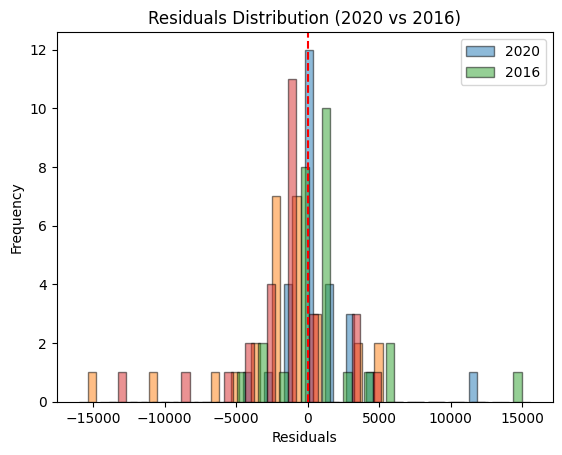

In [62]:
#histogram of residuals for 2020 data
plt.hist(residuals_2020, bins=20, edgecolor='black', alpha=0.5, label='2020')
#histogram of residuals for 2016 data
plt.hist(residuals_2016, bins=20, edgecolor='black', alpha=0.5, label='2016')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution (2020 vs 2016)')
plt.legend()
plt.axvline(x=0, color='red', linestyle='--')
plt.show()

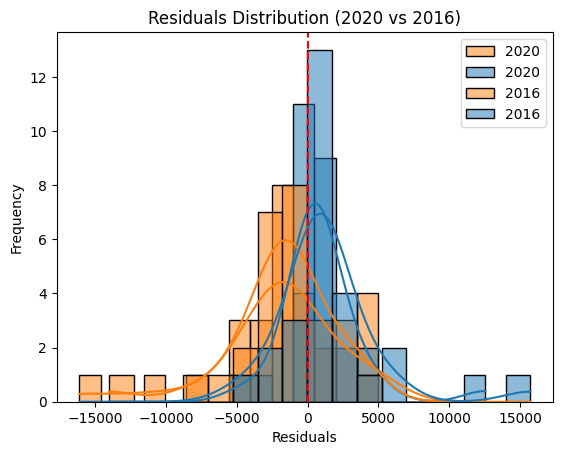

In [63]:
#residuals plot for 2020 data
sns.histplot(residuals_2020, kde=True, color='blue', alpha=0.5, label='2020')
#residuals plot for 2016 data
sns.histplot(residuals_2016, kde=True, color='green', alpha=0.5, label='2016')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution (2020 vs 2016)')
plt.legend()
plt.axvline(x=0, color='red', linestyle='--')
plt.show()

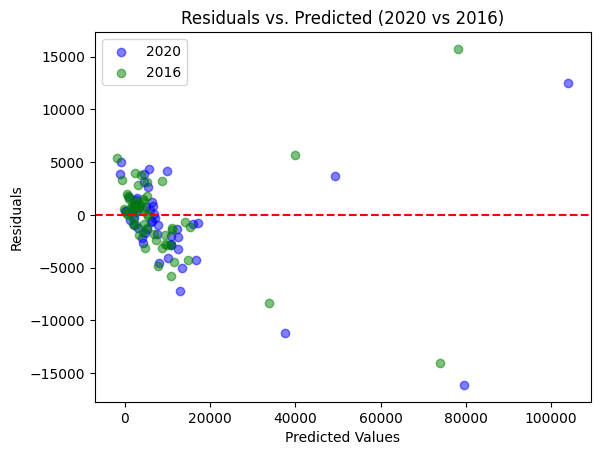

In [64]:
#scatter plot for 2020 data
plt.scatter(y_test_pred_2020, residuals_2020, alpha=0.5, color='blue', label='2020')
#scatter plot for 2016 data
plt.scatter(y_test_pred_2016, residuals_2016, alpha=0.5, color='green', label='2016')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted (2020 vs 2016)')
plt.legend()
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

###Prediction for 2024 election

In [65]:
#merge 2016 and 2020 data with df
df = df.merge(Rvotes_2016, left_on='FIPS_left', right_on='county_fips', suffixes=('_2024', '_2016'))
df = df.merge(Dvotes_2016, left_on='FIPS_left', right_on='county_fips', suffixes=('_2024', '_2016'))
df = df.merge(Rvotes, left_on='FIPS_left', right_on='county_fips', suffixes=('_2024', '_2020'))
df = df.merge(Dvotes, left_on='FIPS_left', right_on='county_fips', suffixes=('_2024', '_2020'))

In [66]:
#predict 2024 votes using the 2020 model
y_pred_numeric_2024_2020 = linear_reg_numeric_2020.predict(X_numeric)
predicted_votes_2024_2020 = pd.DataFrame(y_pred_numeric_2024_2020, columns=['Dem_2024_2020', 'Repub_2024_2020'])

#predict 2024 votes using the 2016 model
y_pred_numeric_2024_2016 = linear_reg_numeric_2016.predict(X_numeric)
predicted_votes_2024_2016 = pd.DataFrame(y_pred_numeric_2024_2016, columns=['Dem_2024_2016', 'Repub_2024_2016'])

In [67]:
df = pd.concat([df, predicted_votes_2024_2020, predicted_votes_2024_2016], axis=1)

In [68]:
#calculate vote difference
df['vote_difference_2024_2020'] = df['Dem_2024_2020'] - df['Repub_2024_2020']
df['vote_difference_2024_2016'] = df['Dem_2024_2016'] - df['Repub_2024_2016']

In [69]:
#group by name and sum votes
county_diff_2024_2020 = df.groupby('NAME').agg({
    'Dem_2024_2020': 'sum',
    'Repub_2024_2020': 'sum',
    'vote_difference_2024_2020': 'sum'
}).reset_index()

county_diff_2024_2016 = df.groupby('NAME').agg({
    'Dem_2024_2016': 'sum',
    'Repub_2024_2016': 'sum',
    'vote_difference_2024_2016': 'sum'
}).reset_index()

In [70]:
#aggregation function to count positive, negative, and zero vote differences
def count_positive_negative_zero(x):
    positive_count = np.sum(x > 0)
    negative_count = np.sum(x < 0)
    zero_count = np.sum(x == 0)
    return pd.Series([positive_count, negative_count, zero_count], index=['positive_count', 'negative_count', 'zero_count'])

In [71]:
#total counts for each model
county_diff_counts_2024_2020 = county_diff_2024_2020['vote_difference_2024_2020'].apply(count_positive_negative_zero)
county_diff_counts_2024_2016 = county_diff_2024_2016['vote_difference_2024_2016'].apply(count_positive_negative_zero)

total_positive_count_2024_2020 = county_diff_counts_2024_2020['positive_count'].sum()
total_negative_count_2024_2020 = county_diff_counts_2024_2020['negative_count'].sum()
total_zero_count_2024_2020 = county_diff_counts_2024_2020['zero_count'].sum()

total_positive_count_2024_2016 = county_diff_counts_2024_2016['positive_count'].sum()
total_negative_count_2024_2016 = county_diff_counts_2024_2016['negative_count'].sum()
total_zero_count_2024_2016 = county_diff_counts_2024_2016['zero_count'].sum()


In [73]:
print("Total counties with positive vote difference (2024) - 2020 model:", total_positive_count_2024_2020)
print("Total counties with negative vote difference (2024) - 2020 model:", total_negative_count_2024_2020)

print("Total counties with positive vote difference (2024) - 2016 model:", total_positive_count_2024_2016)
print("Total counties with negative vote difference (2024) - 2016 model:", total_negative_count_2024_2016)

Total counties with positive vote difference (2024) - 2020 model: 7
Total counties with negative vote difference (2024) - 2020 model: 2
Total counties with positive vote difference (2024) - 2016 model: 5
Total counties with negative vote difference (2024) - 2016 model: 4


####Positive Vote Difference= Democrats get more votes

####Negative Vote Difference= Republicans get more votes

####In 2020 model, democrats predicted to get more votes in 7 counties and republicans in 2

####In 2016 model, democrats predicted to get more votes in 5 counties and republicans in 4



In [82]:
#total vote difference for 2024 based on predictions from the 2020 model
total_vote_difference_2024_2020 = df['vote_difference_2024_2020'].sum()

#total vote difference for 2024 based on predictions from the 2016 model
total_vote_difference_2024_2016 = df['vote_difference_2024_2016'].sum()

#total vote difference for 2024 from both models
print("Total Vote Difference for 2024 (2020 Model):", total_vote_difference_2024_2020)
print("Total Vote Difference for 2024 (2016 Model):", total_vote_difference_2024_2016)


Total Vote Difference for 2024 (2020 Model): 455261.8228749843
Total Vote Difference for 2024 (2016 Model): 182096.47656058322


####In 2020 Model, democrats predicted to win by 455,261 votes

####In 2016 Model, democrats predicted to win by 182,096 votes


###Tried VA plots but not enough 2024 data

<Axes: >

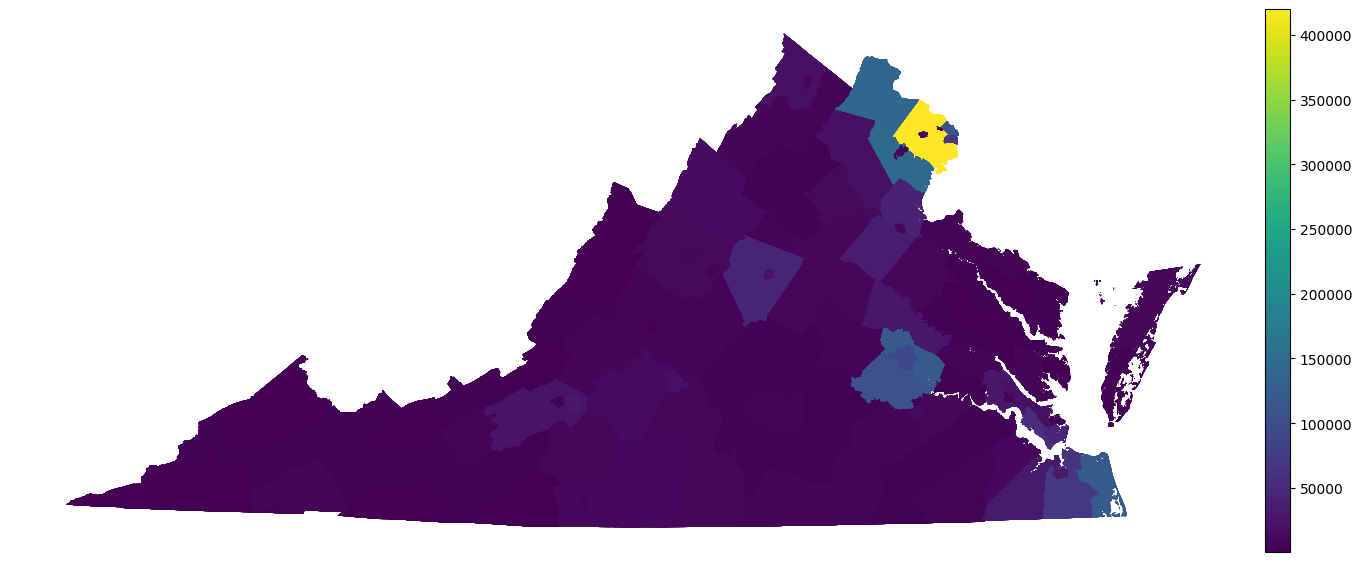

In [75]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 2, 2])
divider = make_axes_locatable(ax)
ax.axis('off')
cax = divider.append_axes("right", size="2%", pad=0.08)
df.plot(ax=ax,column='dem_2020',legend=True,cax=cax)

<Axes: >

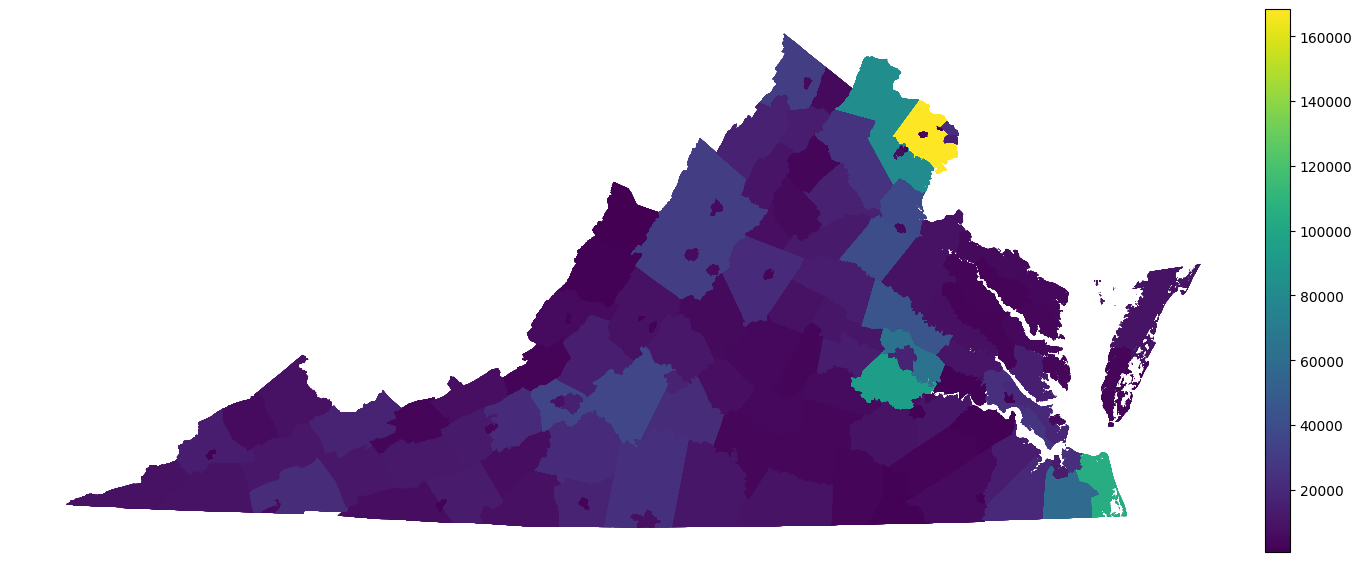

In [76]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 2, 2])
divider = make_axes_locatable(ax)
ax.axis('off')
cax = divider.append_axes("right", size="2%", pad=0.08)
df.plot(ax=ax,column='repub_2020',legend=True,cax=cax)

<Axes: >

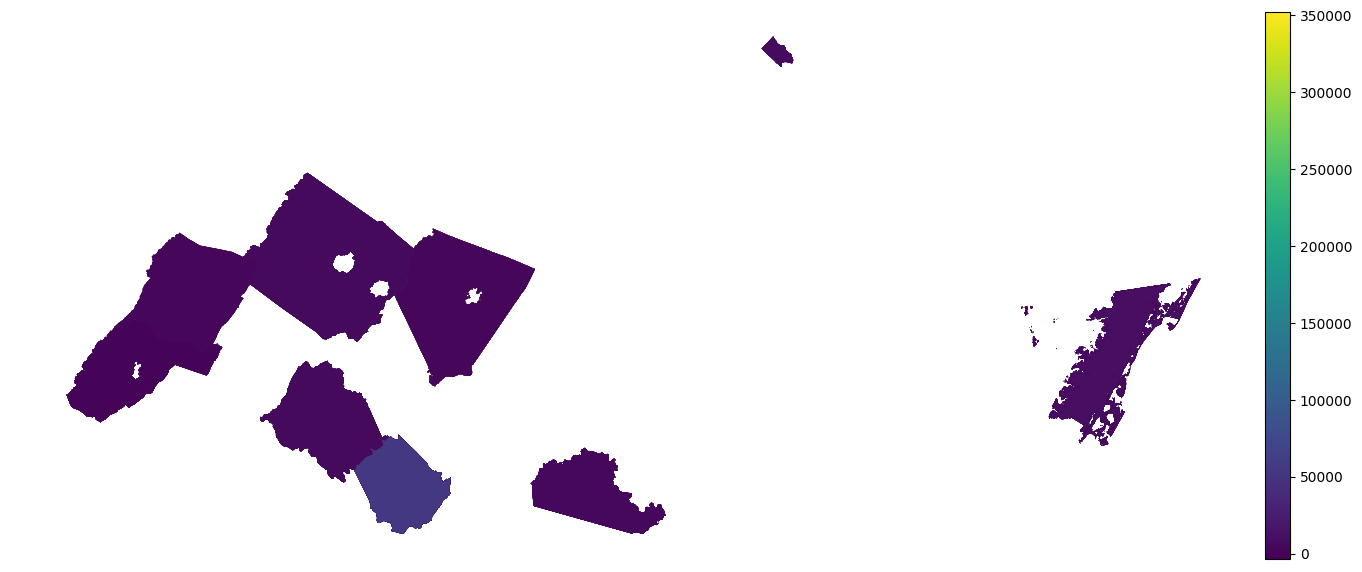

In [79]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 2, 2])
divider = make_axes_locatable(ax)
ax.axis('off')
cax = divider.append_axes("right", size="2%", pad=0.08)
df.plot(ax=ax,column='Dem_2024_2016',legend=True,cax=cax)

<Axes: >

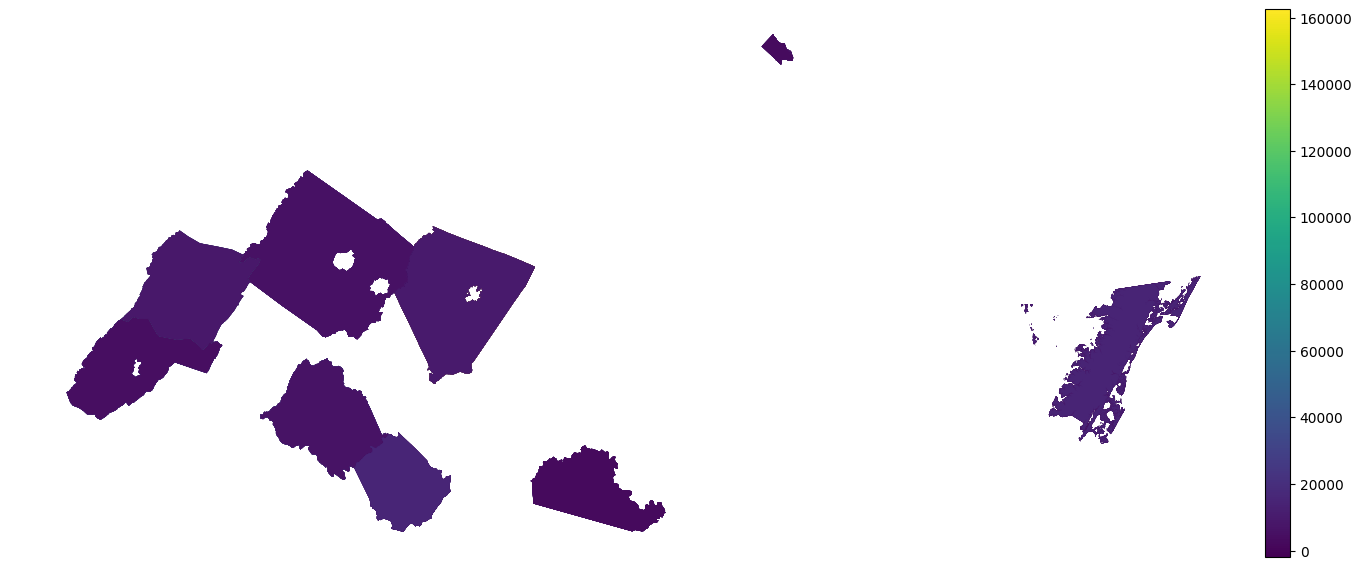

In [80]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 2, 2])
divider = make_axes_locatable(ax)
ax.axis('off')
cax = divider.append_axes("right", size="2%", pad=0.08)
df.plot(ax=ax,column='Repub_2024_2016',legend=True,cax=cax)

<Axes: >

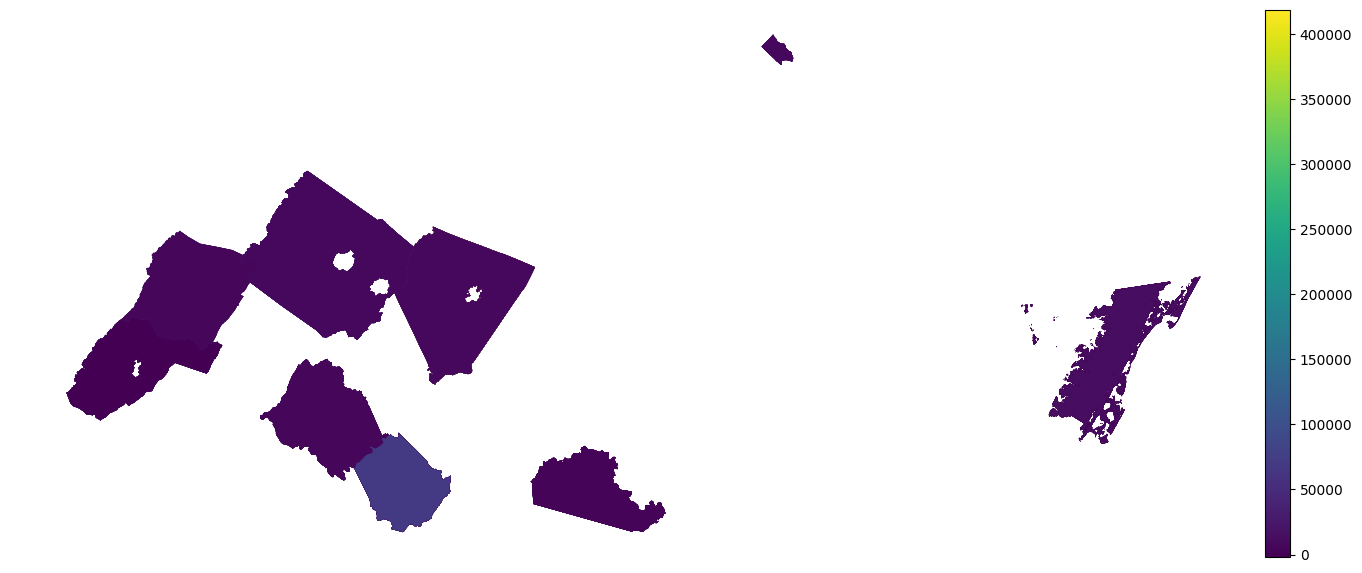

In [78]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 2, 2])
divider = make_axes_locatable(ax)
ax.axis('off')
cax = divider.append_axes("right", size="2%", pad=0.08)
df.plot(ax=ax,column='Dem_2024_2020',legend=True,cax=cax)

<Axes: >

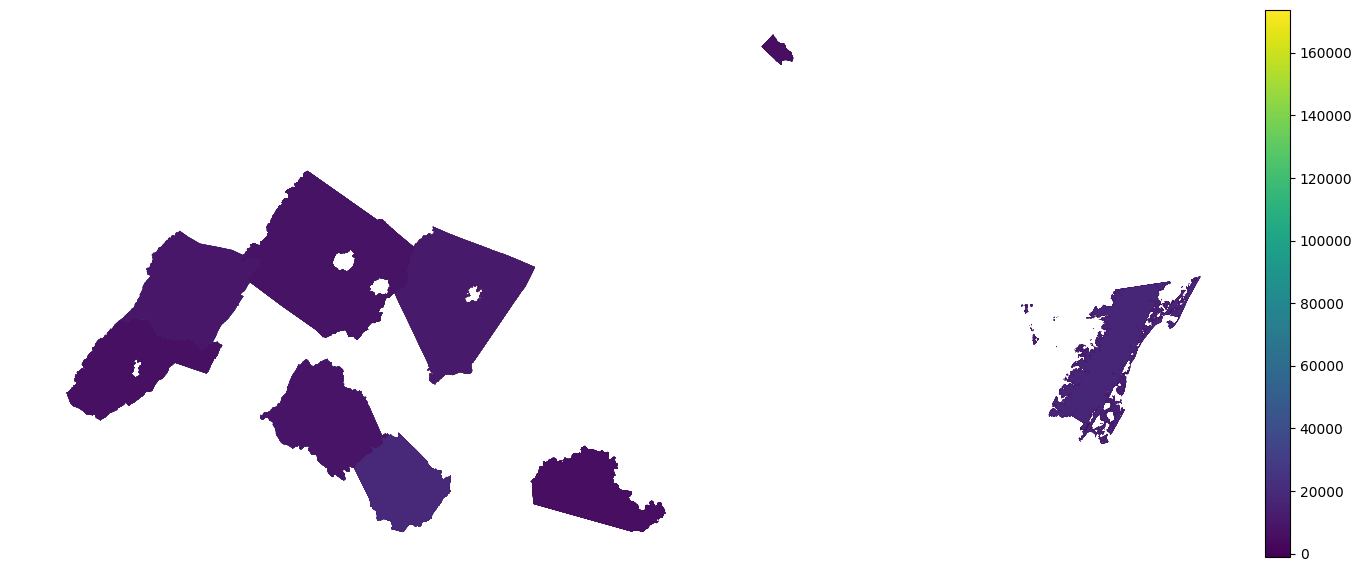

In [81]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 2, 2])
divider = make_axes_locatable(ax)
ax.axis('off')
cax = divider.append_axes("right", size="2%", pad=0.08)
df.plot(ax=ax,column='Repub_2024_2020',legend=True,cax=cax)